# Modelos para probabilidad de respuesta

Importamos librerías:

In [ ]:
# Librerías generales
import os
import numpy as np
import pandas as pd
# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Modelos
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Regresión logística
from sklearn.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix
from ISLP.models import (ModelSpec,
                         Stepwise,
                         sklearn_selected)

# Selección de variables
from ISLP.models import (Stepwise,sklearn_selected)  # Para selección de variables (ISLP)
from sklearn.feature_selection import SequentialFeatureSelector # Selección de variables (CV)
import contextlib

Seteamos el directorio de trabajo:

In [93]:
os.chdir('C:/Users/celin/OneDrive/Documentos/CELINE/FACULTAD/Maestría en Estadística Aplicada/4to semestre/Tesis/Nonresponse-bias-eph')

Cargamos la base de datos individual (filtrada por el jefe de hogar, para tomar un registro por hogar):

In [94]:
# Cargamos las bases de datos
individual_NEA = pd.read_csv("Bases/individual_NEA_paramodelos.txt", sep=";", low_memory=False)
individual_NEA.head()

,ANO4,TRIMESTRE,CODUSU,NRO_HOGAR,periodo,AGLOMERADO,REGION_DESC,REGION_COD,CH04,CH06,...,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,viviendasxarea
0,2017,2,TQRMNOPPQHJMKRCDEFOCD00472238,1,2017.25,8,Noreste,41,1,62,...,2.0,2.0,2.0,0.0,2.0,0.0,1.0,2.0,1.0,7
1,2017,2,TQRMNOPPQHKMLMCDEGLDF00590955,1,2017.25,15,Noreste,41,2,48,...,1.0,2.0,2.0,0.0,2.0,0.0,3.0,2.0,1.0,3
2,2017,2,TQRMNOPPQHKMLQCDEFOCD00472357,1,2017.25,8,Noreste,41,1,39,...,1.0,1.0,2.0,0.0,2.0,0.0,1.0,2.0,1.0,7
3,2017,2,TQRMNOPPQHKOKOCDEGIBJ00509386,1,2017.25,12,Noreste,41,1,34,...,2.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,9
4,2017,2,TQRMNOPPRHJMKRCDEFOCD00472239,1,2017.25,8,Noreste,41,1,33,...,1.0,2.0,2.0,0.0,2.0,0.0,1.0,2.0,1.0,7


In [95]:
# Dimensión de la base
print("Dimensión de la base total: ", individual_NEA.shape)

Dimensión de la base total:  (36172, 259)


Filtramos por la última entrevista registrada de cada hogar, para no duplicar:

In [96]:
# Filtramos por última entrevista
ult_entrevista = individual_NEA.groupby(['CODUSU','NRO_HOGAR'])['n_entrevista'].idxmax()
individual_NEA = individual_NEA.loc[ult_entrevista].reset_index(drop=True)
# Cantidad de registros
print("Dimensión de la base filtrada: ", individual_NEA.shape)

Dimensión de la base filtrada:  (15814, 259)


In [97]:
# Variables para el modelo
variables = [
    'completo',  # Variable de respuesta
    # Variables de identificación del hogar
    'AGLO_DESC', 'periodo', 'PONDERA_repr', 'viviendasxarea',
    # Ingreso del hogar
    'IPCF_d', 'otros_ing_nolab', 'RDECOCUR',
    # Datos del jefe de hogar
    'CH06', 'CH06_2', 'IX_TOT', 'informal', 'NIVEL_ED', 'mujer', 'casadounido', 'ESTADO', 'CAT_INAC', 'CAT_OCUP',
    # Características de la vivienda
    'IV1', 'IV2', 'IV3', 'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11', 'IV12_1', 'IV12_2', 'IV12_3',
    # Características habitacionales del hogar
    'II1', 'II3', 'II4_1', 'II4_2', 'II4_3', 'II5', 'II7', 'II8', 'II9',
    # Ocupación del jefe de hogar
    #'CALIFICACION', 'JERARQUIA', 'caes_seccion_cod', 'PP04B1',
    # Características de composición del hogar
    'cantidad_varones', 'cantidad_mujeres', 'cantidad_ocupados','cantidad_desocupados', 'cantidad_informales', 'edad_promedio_hogar'
]

# Seleccionamos estos campos en la base de datos
individual_NEA = individual_NEA[variables]

# Estratos para división
individual_NEA['estrato'] = (
    individual_NEA['completo'].astype(str) + '_' +
    individual_NEA['periodo'].astype(str)
)

<positron-console-cell-97>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Convertimos las variables tipo string a categóricas y luego a dummies:

In [58]:
# Convertimos en categóricas las variables tipo object
for col in individual_NEA.select_dtypes(include='object').columns:
    individual_NEA[col] = individual_NEA[col].astype('category')
# Convertimos en dummies las variables categóricas
individual_NEA = pd.get_dummies(individual_NEA, columns=['CALIFICACION','JERARQUIA','caes_seccion_cod','PP04B1'], dtype=int)
# Eliminamos dummies de "No ocupado"
individual_NEA = individual_NEA.drop(
    columns=[
        'CALIFICACION_No ocupado',
        'CALIFICACION_N/s',
        'JERARQUIA_Ns.Nc',
        'JERARQUIA_No ocupado',
        'caes_seccion_cod_No ocupado',
        'PP04B1_No ocupado',
        'PP04B1_No presta',
        'RDECOCUR'
    ])


KeyError: "None of [Index(['CALIFICACION', 'JERARQUIA', 'caes_seccion_cod', 'PP04B1'], dtype='object')] are in the [columns]"

In [98]:
# Dummies de nivel educativo
individual_NEA = pd.get_dummies(individual_NEA, columns=['NIVEL_ED'], drop_first=True, dtype=int)

ESTADO: Condición de actividad
* 0 = Entrevista individual no realizada (no respuesta al cuestionario 
individual) 
* 1 = Ocupado 
* 2 = Desocupado 
* 3 = Inactivo 
* 4 = Menor de 10 años

CAT_OCUP: Categoría ocupacional (Para ocupados y desocupados con ocupación anterior) 
* 1 = Patrón 
* 2 = Cuenta propia 
* 3 = Obrero o empleado 
* 4 = Trabajador familiar sin remuneración 
* 9 = Ns/Nr

In [99]:
for col in ['ESTADO','CAT_OCUP','CAT_INAC']:
    individual_NEA[col] = individual_NEA[col].astype('category')
individual_NEA = pd.get_dummies(individual_NEA, columns=['ESTADO','CAT_OCUP','CAT_INAC'], drop_first=True, dtype=int)

Borramos un par de registros que están mal (controlar esto):

In [100]:
print('Dimensión de la base (antes): ', individual_NEA.shape)
individual_NEA = individual_NEA[
    ~(
        (individual_NEA['completo'] == 1) &
        (individual_NEA['periodo'] == 2019.75) &
        (individual_NEA['AGLO_DESC'] == 'Gran Resistencia')
    )
]

individual_NEA = individual_NEA[
    ~(
        (individual_NEA['completo'] == 1) &
        (individual_NEA['periodo'] == 2020.75) &
        (individual_NEA['AGLO_DESC'] == 'Gran Resistencia')
    )
]
print('Dimensión de la base (después): ', individual_NEA.shape)

Dimensión de la base (antes):  (15814, 60)
Dimensión de la base (después):  (15812, 60)


In [101]:
print('Dimensión de la base (antes): ', individual_NEA.shape)
individual_NEA = individual_NEA.dropna()
print('Dimensión de la base (después): ', individual_NEA.shape)

Dimensión de la base (antes):  (15812, 60)
Dimensión de la base (después):  (15810, 60)


Definimos los vectores y, x y estrato para la división en entrenamiento y test:

In [102]:
# Respuesta de los modelos
y_R = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Gran Resistencia']['completo'])
y_C = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Corrientes']['completo'])
y_F = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Formosa']['completo'])
y_P = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Posadas']['completo'])
# Matriz del modelo
X_R = individual_NEA[individual_NEA['AGLO_DESC']=='Gran Resistencia'].drop(columns=['completo','estrato','AGLO_DESC'])
X_C = individual_NEA[individual_NEA['AGLO_DESC']=='Corrientes'].drop(columns=['completo','estrato','AGLO_DESC'])
X_F = individual_NEA[individual_NEA['AGLO_DESC']=='Formosa'].drop(columns=['completo','estrato','AGLO_DESC'])
X_P = individual_NEA[individual_NEA['AGLO_DESC']=='Posadas'].drop(columns=['completo','estrato','AGLO_DESC'])
# Variables para estratificar
estrato_R = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Gran Resistencia']['estrato'])
estrato_C = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Corrientes']['estrato'])
estrato_F = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Formosa']['estrato'])
estrato_P = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Posadas']['estrato'])

División en entrenamiento y test, dividimos internamente:

In [103]:
X_R_train, X_R_test, y_R_train, y_R_test = train_test_split(X_R, y_R, test_size=0.2, stratify=estrato_R) # Gran Resistencia
X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(X_C, y_C, test_size=0.2, stratify=estrato_C) # Corrientes
X_F_train, X_F_test, y_F_train, y_F_test = train_test_split(X_F, y_F, test_size=0.2, stratify=estrato_F) # Formosa
X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P, y_P, test_size=0.2, stratify=estrato_P) # Posadas

Revisar casos con NAs en las variables regresoras:

## Modelo de regresión logístico

 Realizamos selección de variables usando stepwise forward selection para el modelo logístico (escalamos variables previamente):

In [148]:
def negAIC(estimator, X, Y):
    "Negative AIC"
    n, p = X.shape
    Yhat = estimator.predict(X)
    MSE = np.mean((Y - Yhat)**2)
    return n + n * np.log(MSE) + 2 * (p + 1)

In [149]:
# Diccionario con los datasets
datasets_train = {
    "Gran Resistencia": (X_R_train, y_R_train),
    "Corrientes": (X_C_train, y_C_train),
    "Formosa": (X_F_train, y_F_train),
    "Posadas": (X_P_train, y_P_train)
}

# Matrices de diseño
print('Matrices de diseño. Cálculo.')
designs = {}
for aglo, (X_train, y_train) in datasets_train.items():
    design = ModelSpec(X_train.columns).fit(X_train)
    X_train = design.transform(X_train)
    designs[aglo] = design
    datasets_train[aglo] = (X_train, y_train)
    print(f"✅ Matriz de diseño para {aglo}")

Matrices de diseño. Cálculo.
✅ Matriz de diseño para Gran Resistencia
✅ Matriz de diseño para Corrientes
✅ Matriz de diseño para Formosa
✅ Matriz de diseño para Posadas


In [106]:
# Diccionario para modelos ajustados
modelos = {}

# Stepwise
for aglo, (X_train, y_train) in datasets_train.items():
    
    # Establecemos estrategia
    print(f'Trabajando con {aglo}...')    
    design = designs[aglo]
    strategy = Stepwise.first_peak(
        design, 
        direction='forward',
        max_terms=len(design.terms)
    )

    # Corremos stepwise
    #modelo_LR = LogisticRegression(class_weight='balanced')
    modelo = sklearn_selected(
        sm.Logit,
        strategy,
        scoring=negAIC
    )
    print(f"✅ Stepwise para {aglo}")

    # Ajustamos el modelo
    with contextlib.redirect_stdout(None):
        modelo.fit(X_train, y_train)
        modelos[aglo] = modelo 
    print(f"✅ Modelo ajustado para {aglo}")

Trabajando con Resistencia...
✅ Stepwise para Resistencia


C:\Users\celin\anaconda3\envs\islp\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\celin\anaconda3\envs\islp\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\celin\anaconda3\envs\islp\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\celin\anaconda3\envs\islp\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\celin\anaconda3\envs\islp\Lib\site-packages\statsmo

LinAlgError: Singular matrix

In [150]:
# Definimos el modelo base
def build_model():
    return make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced')
    )

# Diccionario con los datasets
datasets_train = {
    "Gran Resistencia": (X_R_train, y_R_train),
    "Corrientes": (X_C_train, y_C_train),
    "Formosa": (X_F_train, y_F_train),
    "Posadas": (X_P_train, y_P_train)
}

# Entrenar un modelo SFS por cada dataset
modelos_sfs = {}
for aglo, (X_train, y_train) in datasets_train.items():
    modelo = build_model()
    sfs = SequentialFeatureSelector(modelo, direction='forward')
    sfs.fit(X_train, y_train)
    modelos_sfs[aglo] = sfs
    print(f"✅ Modelo entrenado para {aglo}")

✅ Modelo entrenado para Gran Resistencia
✅ Modelo entrenado para Corrientes
✅ Modelo entrenado para Formosa
✅ Modelo entrenado para Posadas


In [151]:
# Diccionario para guardar las columnas seleccionadas por cada modelo
features_seleccionadas = {}

for aglo, selector in modelos_sfs.items():
    # Tomamos cualquier X_train correspondiente para obtener los nombres de columnas
    X_train, _ = datasets_train[aglo]
    
    # Transformamos para obtener columnas seleccionadas (mask booleana)
    mask = selector.get_support()  # True si la columna fue seleccionada
    cols_seleccionadas = X_train.columns[mask]
    
    features_seleccionadas[aglo] = list(cols_seleccionadas)

# Mostrar resultados
for aglo, cols in features_seleccionadas.items():
    print(f"{aglo}: {cols}")


Gran Resistencia: ['otros_ing_nolab', 'IV3', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV12_1', 'IV12_2', 'IV12_3', 'II3', 'II4_1', 'II4_2', 'II5', 'II8', 'II9', 'cantidad_desocupados', 'NIVEL_ED_Secundario completo', 'NIVEL_ED_Secundario incompleto', 'ESTADO_2', 'CAT_OCUP_1', 'CAT_OCUP_4', 'CAT_INAC_2', 'CAT_INAC_3', 'CAT_INAC_4', 'CAT_INAC_6', 'CAT_INAC_7']
Corrientes: ['PONDERA_repr', 'viviendasxarea', 'IPCF_d', 'otros_ing_nolab', 'informal', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV12_1', 'IV12_3', 'II3', 'II4_2', 'II4_3', 'II7', 'II8', 'II9', 'cantidad_varones', 'NIVEL_ED_Universitario completo', 'ESTADO_2', 'CAT_OCUP_1', 'CAT_OCUP_2', 'CAT_OCUP_4', 'CAT_INAC_2', 'CAT_INAC_4', 'CAT_INAC_6', 'CAT_INAC_7']
Formosa: ['otros_ing_nolab', 'CH06', 'IX_TOT', 'casadounido', 'IV1', 'IV2', 'IV6', 'IV7', 'IV8', 'IV10', 'IV11', 'IV12_1', 'IV12_3', 'II3', 'II7', 'II8', 'II9', 'cantidad_ocupados', 'cantidad_desocupados', 'NIVEL_ED_Secundario incompleto', 'NIVEL_ED_Universitario completo', 'ESTAD

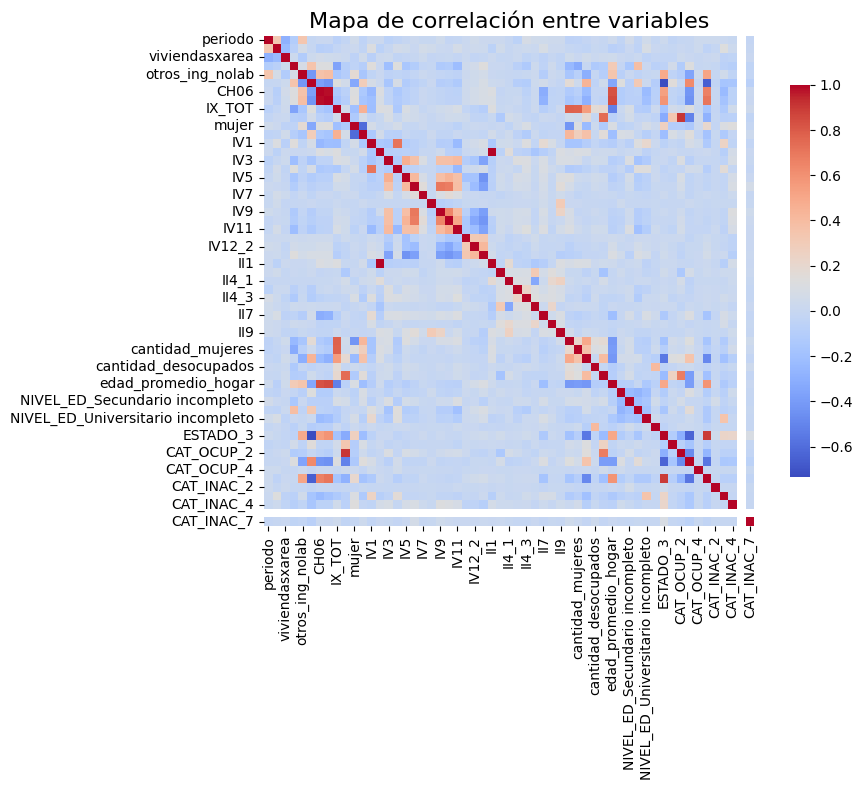

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tenés un DataFrame df con variables numéricas
# Calculamos la matriz de correlación
corr_matrix = X_train.corr()

# Visualizamos el mapa de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Mapa de correlación entre variables", fontsize=16)
plt.tight_layout()
plt.show()

In [111]:
# Matriz de correlación
corr_matrix = X_train.corr()

# Convertir en formato largo (pares de variables)
corr_pairs = corr_matrix.unstack()

# Eliminar duplicados y autocomparaciones (correlación 1.0)
corr_pairs = corr_pairs.drop(labels=[(col, col) for col in corr_matrix.columns])

# Ordenar por valor absoluto de correlación
corr_pairs_sorted = corr_pairs.reindex(corr_pairs.abs().sort_values(ascending=False).index)

# Mostrar las 10 correlaciones más altas
print(corr_pairs_sorted.head(10))

II1                  IV2                    0.995905
IV2                  II1                    0.995905
CH06_2               CH06                   0.984529
CH06                 CH06_2                 0.984529
CAT_OCUP_2           informal               0.905700
informal             CAT_OCUP_2             0.905700
ESTADO_3             CAT_INAC_1             0.892858
CAT_INAC_1           ESTADO_3               0.892858
edad_promedio_hogar  CH06_2                 0.844734
CH06_2               edad_promedio_hogar    0.844734
dtype: float64


In [152]:
modelos_logit = {}
for aglo, (X_train, y_train) in datasets_train.items():
    # Selecciona las columnas usando el selector correspondiente
    selected_features = modelos_sfs[aglo]  # tu selector
    X_train_selected = selected_features.transform(X_train)
    # Ajustar modelo
    modelo_logit = LogisticRegression(verbose=1, class_weight='balanced')
    modelo_logit.fit(X_train_selected, y_train)
    # Guardar modelo ajustado
    modelos_logit[aglo] = modelo_logit

C:\Users\celin\anaconda3\envs\islp\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\celin\anaconda3\envs\islp\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

In [153]:
# Función para calcular métricas
def calcular_metricas(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    sens = recall_score(y_test, y_pred, pos_label=1)   # Sensibilidad
    esp = recall_score(y_test, y_pred, pos_label=0)    # Especificidad
    vpp = precision_score(y_test, y_pred, pos_label=1) # Valor Predictivo Positivo
    vpn = precision_score(y_test, y_pred, pos_label=0) # Valor Predictivo Negativo
    
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    return {
        "accuracy": round(acc,5),
        "sensibilidad": round(sens,5),
        "especificidad": round(esp,5),
        "VPP": round(vpp,5),
        "VPN": round(vpn,5),
        "auc": round(auc,5) if auc is not None else None
    }

# Diccionario con datasets de train/test
datasets = {
    "Gran Resistencia": (X_R_train, X_R_test, y_R_train, y_R_test),
    "Corrientes": (X_C_train, X_C_test, y_C_train, y_C_test),
    "Formosa": (X_F_train, X_F_test, y_F_train, y_F_test),
    "Posadas": (X_P_train, X_P_test, y_P_train, y_P_test)
}

In [154]:
# DataFrame vacío para guardar resultados
resultados = pd.DataFrame()

# Entrenamos y evaluamos
for aglo, (X_train, X_test, y_train, y_test) in datasets.items():
    # Modelo seleccionado
    modelo = modelos_logit[aglo]
    # Variables seleccionadas
    selected_features = modelos_sfs[aglo]  # tu selector
    X_test_selected = selected_features.transform(X_test)
    # Calculamos métricas de clasificación
    metricas = calcular_metricas(modelo, X_test_selected, y_test)
    metricas["Modelo"] = "Logistic Regression"
    metricas["Aglomerado"] = aglo
    print(f"✅ Métricas calculadas para {aglo}")

    # Probabilidad promedio estimada
    probs = modelo.predict_proba(X_test_selected)[:,1] if hasattr(modelo, "predict_proba") else None
    prob_promedio = probs.mean()
    metricas['prob_mean'] = prob_promedio

    # Concatenamos resultados
    resultados = pd.concat([resultados, pd.DataFrame([metricas])], ignore_index=True)

✅ Métricas calculadas para Gran Resistencia
✅ Métricas calculadas para Corrientes
✅ Métricas calculadas para Formosa
✅ Métricas calculadas para Posadas


In [155]:
resultados

,accuracy,sensibilidad,especificidad,VPP,VPN,auc,Modelo,Aglomerado,prob_mean
0,0.61932,0.46552,0.67438,0.33856,0.77897,0.59649,Logistic Regression,Gran Resistencia,0.496516
1,0.60246,0.57025,0.63415,0.60526,0.60000,0.63340,Logistic Regression,Corrientes,0.493642
2,0.59453,0.65625,0.53810,0.56502,0.63128,0.63265,Logistic Regression,Formosa,0.510482
3,0.66578,0.77201,0.51148,0.69654,0.60700,0.63328,Logistic Regression,Posadas,0.503620


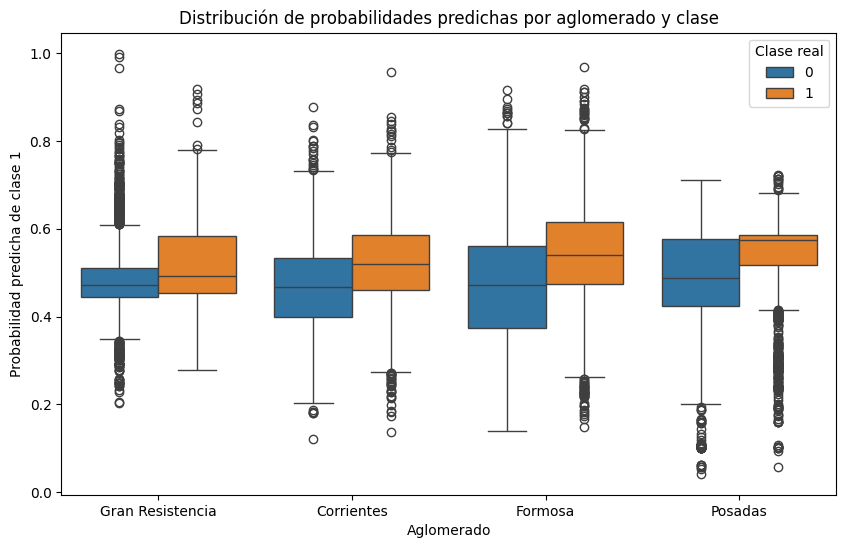

In [156]:
# Concatenamos train + test para cada aglomerado
df_predicciones = pd.DataFrame()

for aglo, (X_train, X_test, y_train, y_test) in datasets.items():
    # Modelo
    modelo = modelos_logit[aglo]
    # Selector de features
    selector = modelos_sfs[aglo]
    
    # Concatenamos X y y
    X_total = pd.concat([X_train, X_test], ignore_index=True)
    y_total = pd.concat([pd.Series(y_train), pd.Series(y_test)], ignore_index=True)
    
    # Seleccionamos las columnas
    X_total_selected = selector.transform(X_total)
    
    # Predicciones
    if hasattr(modelo, "predict_proba"):
        probs = modelo.predict_proba(X_total_selected)[:,1]
    else:
        probs = modelo.predict(X_total_selected)
    
    # Guardamos en un DataFrame
    df_temp = pd.DataFrame({
        "Aglomerado": aglo,
        "y_real": y_total,
        "Prob_pred": probs
    })
    
    df_predicciones = pd.concat([df_predicciones, df_temp], ignore_index=True)

# Boxplot: probabilidad predicha por clase y aglomerado
plt.figure(figsize=(10,6))
sns.boxplot(x="Aglomerado", y="Prob_pred", hue="y_real", data=df_predicciones)
plt.title("Distribución de probabilidades predichas por aglomerado y clase")
plt.ylabel("Probabilidad predicha de clase 1")
plt.xlabel("Aglomerado")
plt.legend(title="Clase real")
plt.show()


Random Forest

In [157]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# Diccionario para guardar modelos
modelos_rf = {}

# Parámetros a ajustar (ejemplo)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

for aglo, (X_train, y_train) in datasets_train.items():

    # Random Forest base
    rf = RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    # Optimizar por AUC
    grid_search = GridSearchCV(
        rf,
        param_grid,
        scoring='recall',  # optimiza por AUC
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    # Ajustar modelo
    grid_search.fit(X_train, y_train)

    # Guardar mejor modelo
    modelos_rf[aglo] = grid_search.best_estimator_

    print(f"Mejores hiperparámetros para {aglo}: {grid_search.best_params_}")
    print(f"Mejor AUC en validación cruzada: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros para Gran Resistencia: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Mejor AUC en validación cruzada: 0.5875
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros para Corrientes: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Mejor AUC en validación cruzada: 0.7583
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros para Formosa: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mejor AUC en validación cruzada: 0.7422
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros para Posadas: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor AUC en validación cruzada: 0.8433


In [158]:
# Entrenamos y evaluamos
for aglo, (X_train, X_test, y_train, y_test) in datasets.items():
    # Modelo seleccionado
    modelo = modelos_rf[aglo]
    # Calculamos métricas de clasificación
    metricas = calcular_metricas(modelo, X_test, y_test)
    metricas["Modelo"] = "Random Forest"
    metricas["Aglomerado"] = aglo
    print(f"✅ Métricas calculadas para {aglo}")

    # Probabilidad promedio estimada
    probs = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, "predict_proba") else None
    prob_promedio = probs.mean()
    metricas['prob_mean'] = prob_promedio

    # Concatenamos resultados
    resultados = pd.concat([resultados, pd.DataFrame([metricas])], ignore_index=True)

✅ Métricas calculadas para Gran Resistencia
✅ Métricas calculadas para Corrientes
✅ Métricas calculadas para Formosa
✅ Métricas calculadas para Posadas


In [159]:
resultados

,accuracy,sensibilidad,especificidad,VPP,VPN,auc,Modelo,Aglomerado,prob_mean
0,0.61932,0.46552,0.67438,0.33856,0.77897,0.59649,Logistic Regression,Gran Resistencia,0.496516
1,0.60246,0.57025,0.63415,0.60526,0.60000,0.63340,Logistic Regression,Corrientes,0.493642
2,0.59453,0.65625,0.53810,0.56502,0.63128,0.63265,Logistic Regression,Formosa,0.510482
3,0.66578,0.77201,0.51148,0.69654,0.60700,0.63328,Logistic Regression,Posadas,0.503620
4,0.70341,0.61207,0.73611,0.45367,0.84127,0.72694,Random Forest,Gran Resistencia,0.470906
5,0.66393,0.77135,0.55827,0.63205,0.71280,0.71587,Random Forest,Corrientes,0.499413
6,0.62811,0.74479,0.52143,0.58727,0.69085,0.67047,Random Forest,Formosa,0.503431
7,0.70722,0.83747,0.51803,0.71622,0.68696,0.75201,Random Forest,Posadas,0.585515


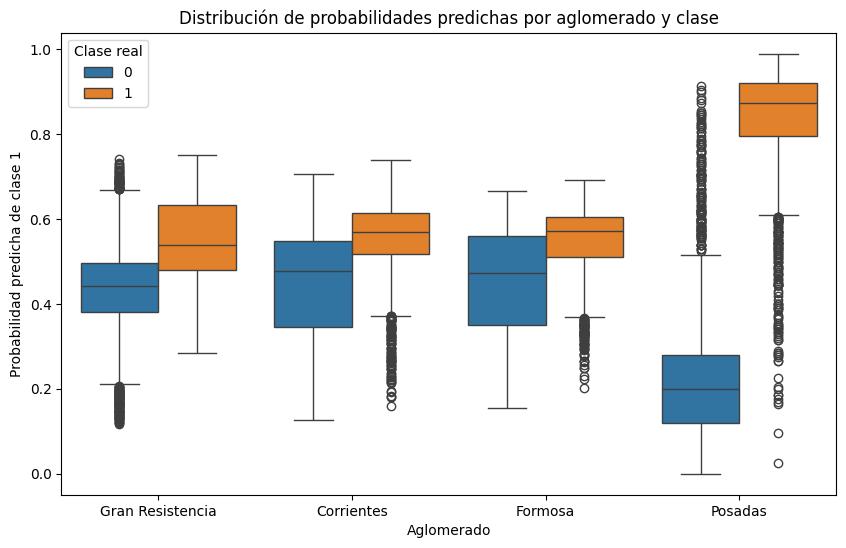

In [160]:
# Concatenamos train + test para cada aglomerado
df_predicciones = pd.DataFrame()

for aglo, (X_train, X_test, y_train, y_test) in datasets.items():
    # Modelo
    modelo = modelos_rf[aglo]
    
    # Concatenamos X y y
    X_total = pd.concat([X_train, X_test], ignore_index=True)
    y_total = pd.concat([pd.Series(y_train), pd.Series(y_test)], ignore_index=True)
    
    # Predicciones
    if hasattr(modelo, "predict_proba"):
        probs = modelo.predict_proba(X_total)[:,1]
    else:
        probs = modelo.predict(X_total)
    
    # Guardamos en un DataFrame
    df_temp = pd.DataFrame({
        "Aglomerado": aglo,
        "y_real": y_total,
        "Prob_pred": probs
    })
    
    df_predicciones = pd.concat([df_predicciones, df_temp], ignore_index=True)

# Boxplot: probabilidad predicha por clase y aglomerado
plt.figure(figsize=(10,6))
sns.boxplot(x="Aglomerado", y="Prob_pred", hue="y_real", data=df_predicciones)
plt.title("Distribución de probabilidades predichas por aglomerado y clase")
plt.ylabel("Probabilidad predicha de clase 1")
plt.xlabel("Aglomerado")
plt.legend(title="Clase real")
plt.show()


In [161]:
# Diccionario para guardar DataFrames con importancias
importancias_por_modelo = {}

for aglo, modelo in modelos_rf.items():

    # Extraer importancias
    importancias = modelo.feature_importances_

    # Crear DataFrame ordenado
    df_importancias = pd.DataFrame({
        'Variable': X_train.columns,
        'Importancia': importancias
    }).sort_values(by='Importancia', ascending=False)

    importancias_por_modelo[aglo] = df_importancias

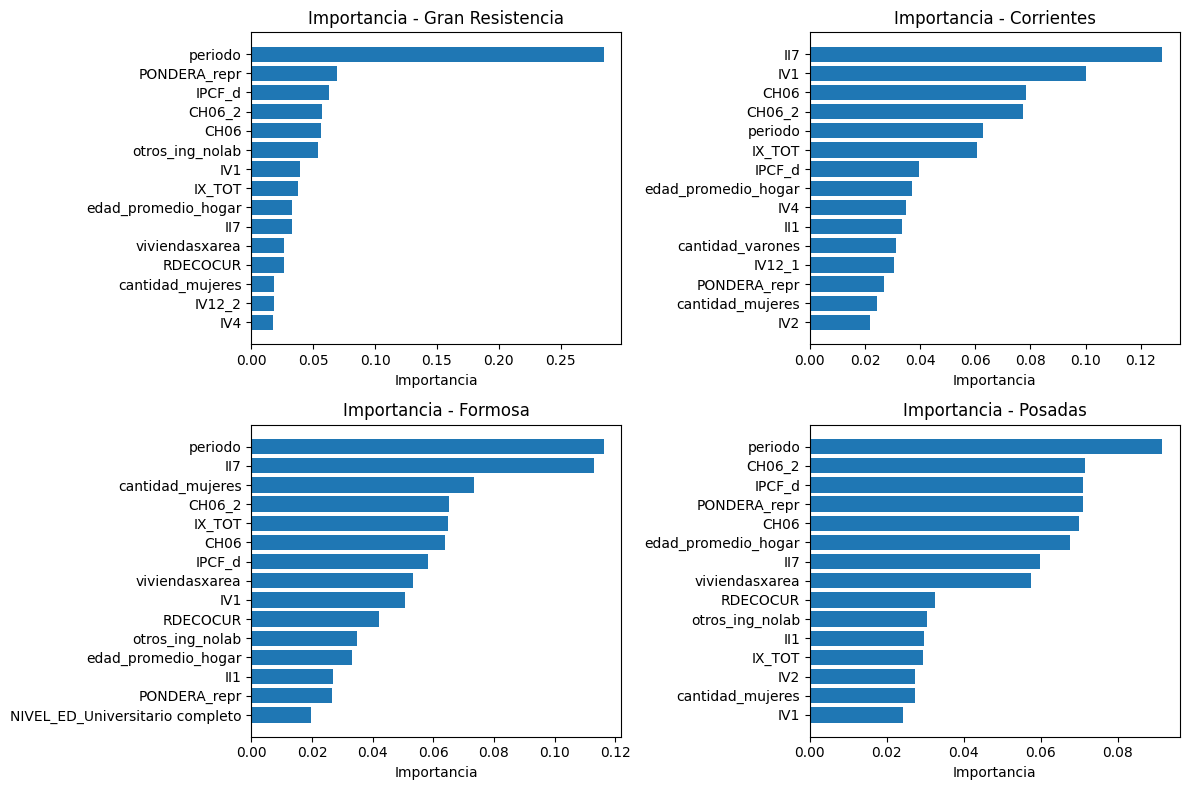

In [162]:
# Crear figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Para indexar fácilmente los subplots

for i, (aglo, df_imp) in enumerate(importancias_por_modelo.items()):
    ax = axes[i]
    top_vars = df_imp.head(15)  # Top 15
    ax.barh(top_vars['Variable'], top_vars['Importancia'])
    ax.invert_yaxis()
    ax.set_title(f"Importancia - {aglo}")
    ax.set_xlabel("Importancia")

plt.tight_layout()
plt.show()

Predicción sobre la base completa

In [163]:
# Cargamos las bases de datos
individual_NEA = pd.read_csv("Bases/individual_NEA_paramodelos.txt", sep=";", low_memory=False)

# Creamos dummies
individual_NEA = pd.get_dummies(individual_NEA, columns=['NIVEL_ED'], drop_first=True, dtype=int)
for col in ['ESTADO','CAT_OCUP','CAT_INAC']:
    individual_NEA[col] = individual_NEA[col].astype('category')
individual_NEA = pd.get_dummies(individual_NEA, columns=['ESTADO','CAT_OCUP','CAT_INAC'], drop_first=True, dtype=int)


In [164]:
individual_NEA['AGLO_DESC'].value_counts()

AGLO_DESC
Formosa             9446
Gran Resistencia    9106
Posadas             8943
Corrientes          8677
Name: count, dtype: int64

In [168]:
# Copia del DataFrame para no modificar el original
individual_NEA['prob_rf'] = np.nan  # columna para probabilidades

for aglo in modelos_rf.keys():

    # Modelo
    modelo = modelos_rf[aglo]

    # Filtrar filas del aglomerado
    mask = individual_NEA['AGLO_DESC'] == aglo
    X = individual_NEA.loc[mask].copy()

    # Seleccionar columnas que estuvieron en X_train
    X_train = datasets[aglo][0]
    columnas_usadas = X_train.columns  # suposición: X_train es un dict por aglo
    X_selected = X[columnas_usadas]

    # Predecir probabilidad de clase positiva
    proba = modelo.predict_proba(X_selected)[:, 1]

    # Asignar al DataFrame original
    individual_NEA.loc[mask, 'prob_rf'] = proba

individual_NEA.head()

,ANO4,TRIMESTRE,CODUSU,NRO_HOGAR,periodo,AGLOMERADO,REGION_DESC,REGION_COD,CH04,CH06,...,CAT_OCUP_2,CAT_OCUP_3,CAT_OCUP_4,CAT_INAC_1,CAT_INAC_2,CAT_INAC_3,CAT_INAC_4,CAT_INAC_6,CAT_INAC_7,prob_rf
0,2017,2,TQRMNOPPQHJMKRCDEFOCD00472238,1,2017.25,8,Noreste,41,1,62,...,0,1,0,0,0,0,0,0,0,0.524746
1,2017,2,TQRMNOPPQHKMLMCDEGLDF00590955,1,2017.25,15,Noreste,41,2,48,...,0,0,0,1,0,0,0,0,0,0.278867
2,2017,2,TQRMNOPPQHKMLQCDEFOCD00472357,1,2017.25,8,Noreste,41,1,39,...,0,1,0,0,0,0,0,0,0,0.448740
3,2017,2,TQRMNOPPQHKOKOCDEGIBJ00509386,1,2017.25,12,Noreste,41,1,34,...,1,0,0,0,0,0,0,0,0,0.395158
4,2017,2,TQRMNOPPRHJMKRCDEFOCD00472239,1,2017.25,8,Noreste,41,1,33,...,0,0,0,0,0,0,0,0,1,0.419182


In [169]:
individual_NEA.to_csv("Bases/individual_NEA_with_probs.csv", index=False)